In [22]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [23]:
#getting the dataset with 70000 reviews
dataset, info = tfds.load('glue/sst2', with_info=True)
print(info.features)
print(info.features["label"].num_classes)
print(info.features["label"].names)

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence': Text(shape=(), dtype=tf.string),
})
2
['negative', 'positive']


In [24]:
#getting training and validation dataset
dataset_train, dataset_validation = dataset['train'], dataset['validation']
dataset_train

<DatasetV1Adapter shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>

In [25]:
#printing some entries
for example in dataset_train.take(2):  
  review, label = example["sentence"], example["label"]
  print("Review:", review)
  print("Label: %d \n" % label.numpy())

Review: tf.Tensor(b'for the uninitiated plays better on video with the sound ', shape=(), dtype=string)
Label: 0 

Review: tf.Tensor(b'like a giant commercial for universal studios , where much of the action takes place ', shape=(), dtype=string)
Label: 0 



In [26]:
# Get the sentences and the labels
# for both the training and the validation sets
training_reviews = []
training_labels = []
 
validation_reviews = []
validation_labels = []

# The dataset has 67,000 training entries, but that's a lot to process here!

# If you want to take the entire dataset: WARNING: takes longer!!
# for item in dataset_train.take(-1):

# Take 10,000 reviews
#for item in dataset_train.take(10000):
for item in dataset_train.take(-1):#takinh all the reviews
  review, label = item["sentence"], item["label"]
  training_reviews.append(str(review.numpy()))
  training_labels.append(label.numpy())

print ("\nNumber of training reviews is: ", len(training_reviews))

# print some of the reviews and labels
for i in range(0, 2):
  print (training_reviews[i])
  print (training_labels[i])

# Get the validation data
# there's only about 800 items, so take them all
for item in dataset_validation.take(-1):  
  review, label = item["sentence"], item["label"]
  validation_reviews.append(str(review.numpy()))
  validation_labels.append(label.numpy())

print ("\nNumber of validation reviews is: ", len(validation_reviews))

# Print some of the validation reviews and labels
for i in range(0, 2):
  print (validation_reviews[i])
  print (validation_labels[i])



Number of training reviews is:  67349
b'for the uninitiated plays better on video with the sound '
0
b'like a giant commercial for universal studios , where much of the action takes place '
0

Number of validation reviews is:  872
b'a valueless kiddie paean to pro basketball underwritten by the nba . '
0
b"featuring a dangerously seductive performance from the great daniel auteuil , `` sade '' covers the same period as kaufmann 's `` quills '' with more unsettlingly realistic results . "
1


In [27]:
# There's a total of 21224 words in the reviews
# but many of them are irrelevant like with, it, of, on.
# If we take a subset of the training data, then the vocab
# will be smaller.

# A reasonable review might have about 50 words or so,
# so we can set max_length to 50 (but feel free to change it as you like)

vocab_size = 4000
embedding_dim = 16
max_length = 50
trunc_type='post'
pad_type='post'
oov_tok = "<OOV>"



tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index


In [28]:
# Pad the sequences so that they are all the same length
training_sequences = tokenizer.texts_to_sequences(training_reviews)
training_padded = pad_sequences(training_sequences,maxlen=max_length, 
                                truncating=trunc_type, padding=pad_type)

validation_sequences = tokenizer.texts_to_sequences(validation_reviews)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length)

training_labels_final = np.array(training_labels)
validation_labels_final = np.array(validation_labels)

In [29]:
#creating model using embeddings
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),  
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 64,017
Trainable params: 64,017
Non-trainable params: 0
_________________________________________________________________


In [30]:
#training the model
num_epochs = 20
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_labels_final))

Epoch 1/20
2105/2105 [==============================] - 7s 3ms/step - loss: 0.6359 - accuracy: 0.6319 - val_loss: 0.5372 - val_accuracy: 0.7534
Epoch 2/20
2105/2105 [==============================] - 7s 3ms/step - loss: 0.4927 - accuracy: 0.7765 - val_loss: 0.4532 - val_accuracy: 0.8050
Epoch 3/20
2105/2105 [==============================] - 7s 3ms/step - loss: 0.4114 - accuracy: 0.8166 - val_loss: 0.4554 - val_accuracy: 0.8039
Epoch 4/20
2105/2105 [==============================] - 6s 3ms/step - loss: 0.3713 - accuracy: 0.8299 - val_loss: 0.4761 - val_accuracy: 0.7947
Epoch 5/20
2105/2105 [==============================] - 7s 3ms/step - loss: 0.3497 - accuracy: 0.8360 - val_loss: 0.5027 - val_accuracy: 0.7959
Epoch 6/20
2105/2105 [==============================] - 7s 3ms/step - loss: 0.3358 - accuracy: 0.8400 - val_loss: 0.5282 - val_accuracy: 0.7993
Epoch 7/20
2105/2105 [==============================] - 7s 3ms/step - loss: 0.3275 - accuracy: 0.8437 - val_loss: 0.5509 - val_accuracy:

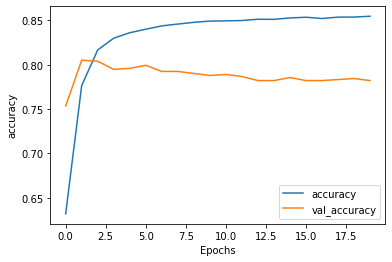

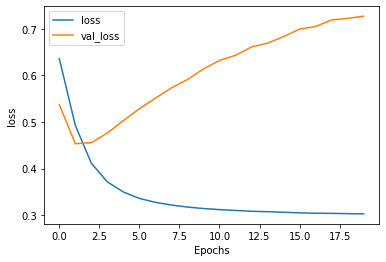

In [31]:
#plotting accuracy and loss
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [32]:
# Write some new reviews 

review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

new_reviews = [review1, review2, review3, review4]

In [33]:
# Define a function to prepare the new reviews for use with a model
# and then use the model to predict the sentiment of the new reviews           

def predict_review(model, reviews):
  # Create the sequences
  padding_type='post'
  sample_sequences = tokenizer.texts_to_sequences(reviews)
  reviews_padded = pad_sequences(sample_sequences, padding=padding_type, 
                                 maxlen=max_length) 
  classes = model.predict(reviews_padded)
  for x in range(len(reviews_padded)):
    print(reviews[x])
    print(classes[x])
    print('\n')

predict_review(model, new_reviews)

I loved this movie
[0.9124177]


that was the worst movie I've ever seen
[0.0036339]


too much violence even for a Bond film
[0.02940845]


a captivating recounting of a cherished myth
[0.8904416]




In [34]:
#funtion to sho and train models with different layers
def fit_model_and_show_results (model, reviews):
  model.summary()
  history = model.fit(training_padded, training_labels_final, epochs=num_epochs, 
                      validation_data=(validation_padded, validation_labels_final))
  plot_graphs(history, "accuracy")
  plot_graphs(history, "loss")
  predict_review(model, reviews)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 46, 16)            1296      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 65,313
Trainable params: 65,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
2105/2105 [==============================] - 8s 4ms/step - loss: 0.6774 - accuracy: 0.5614 - val_loss: 0.6733 - val_accuracy: 0.6525
Epoch 2/30
2105/2105 [==============================] - 7s 3ms/step - loss: 0.5879 - accuracy: 0.7192 - 

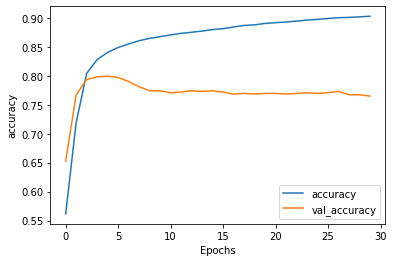

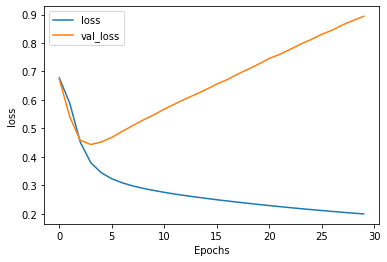

I loved this movie
[0.99967]


that was the worst movie I've ever seen
[8.96861e-05]


too much violence even for a Bond film
[0.05840014]


a captivating recounting of a cherished myth
[0.97110116]




In [35]:
#using a CNN

num_epochs = 30

model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Default learning rate for the Adam optimizer is 0.001
# Let's slow down the learning rate by 10.
learning_rate = 0.0001
model_cnn.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate), 
                  metrics=['accuracy'])

fit_model_and_show_results(model_cnn, new_reviews)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                9600      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 73,665
Trainable params: 73,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
2105/2105 [==============================] - 16s 8ms/step - loss: 0.6861 - accuracy: 0.5545 - val_loss: 0.6964 - val_accuracy: 0.5092
Epoch 2/30
2105/2105 [==============================] - 16s 7ms/step - loss: 0.6547 - accuracy: 0.5883 - val_loss: 0.6136 - val_accuracy: 0.5413
Epoch 3/30
2105/2105 [==============================] - 16s 8ms/step - loss: 0.5535 - accu

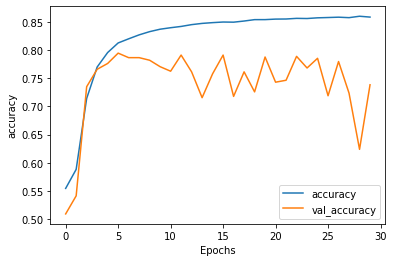

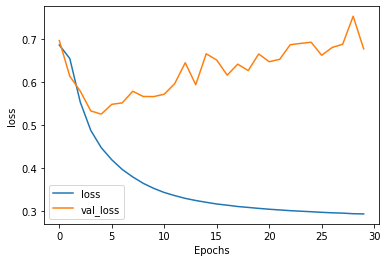

I loved this movie
[0.9230392]


that was the worst movie I've ever seen
[0.00461604]


too much violence even for a Bond film
[0.02406925]


a captivating recounting of a cherished myth
[0.8125193]




In [36]:
#using a GRU

num_epochs = 30

model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00003 # slower than the default learning rate
model_gru.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])

fit_model_and_show_results(model_gru, new_reviews)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 32)                4224      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 68,257
Trainable params: 68,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
2105/2105 [==============================] - 17s 8ms/step - loss: 0.6858 - accuracy: 0.5569 - val_loss: 0.6975 - val_accuracy: 0.5092
Epoch 2/30
2105/2105 [==============================] - 16s 8ms/step - loss: 0.6694 - accuracy: 0.5695 - val_loss: 0.7114 - val_accuracy: 0.5092
Epoch 3/30
2105/2105 [==============================] - 16s 8ms/step - loss: 0.6177 - accu

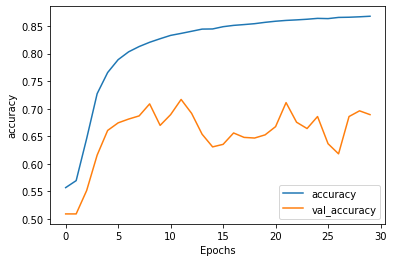

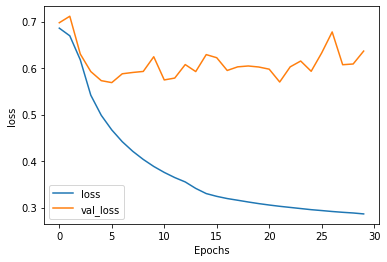

I loved this movie
[0.94683695]


that was the worst movie I've ever seen
[0.02159452]


too much violence even for a Bond film
[0.17459436]


a captivating recounting of a cherished myth
[0.8439638]




In [37]:
#using a bidirectional LSTM
num_epochs = 30

model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00003
model_bidi_lstm.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(learning_rate),
                        metrics=['accuracy'])
fit_model_and_show_results(model_bidi_lstm, new_reviews)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 50, 32)            4224      
_________________________________________________________________
bidirectional_7 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 74,529
Trainable params: 74,529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
2105/2105 [==============================] - 27s 13ms/step - loss: 0.4705 - accuracy: 0.7555 - val_loss: 0.6614 - val_accuracy: 0.5780
Epoch 2/30
2105/2105 [==============================] - 25s 12ms/step - loss: 0.3486 - accuracy: 0.834

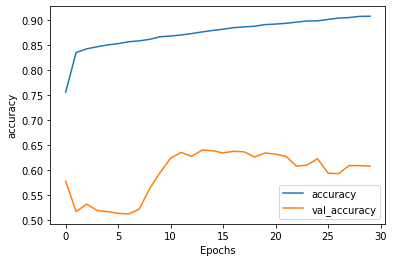

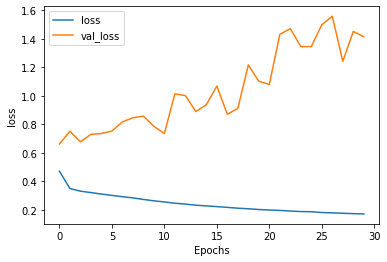

I loved this movie
[0.9995473]


that was the worst movie I've ever seen
[0.00634488]


too much violence even for a Bond film
[0.05214637]


a captivating recounting of a cherished myth
[0.99620444]




In [38]:
#using multilayered bidirectional LSTM
num_epochs = 30

model_multiple_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.0003
model_multiple_bidi_lstm.compile(loss='binary_crossentropy',
                                 optimizer=tf.keras.optimizers.Adam(learning_rate),
                                 metrics=['accuracy'])
fit_model_and_show_results(model_multiple_bidi_lstm, new_reviews)

In [39]:
# Write some new reviews 

review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

review5 = """I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can\'t go wrong with a movie with Whoopi Goldberg in it."""

review6 = """I don\'t understand why it received an oscar recommendation
 for best movie, it was long and boring"""

review7 = """the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!"""

review8 = """The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again"""

review9 = """I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story"""

review10 = "I wish I could watch this movie every day for the rest of my life"

more_reviews = [review1, review2, review3, review4, review5, review6, review7, 
               review8, review9, review10]

In [40]:
print("============================\n","Embeddings only:\n", "============================")
predict_review(model, more_reviews)

 Embeddings only:
I loved this movie
[0.9124177]


that was the worst movie I've ever seen
[0.0036339]


too much violence even for a Bond film
[0.02940845]


a captivating recounting of a cherished myth
[0.8904416]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.9681807]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.9943733]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.36685795]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.6434477]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.00019122]


I wish I could 

In [41]:
print("============================\n","With CNN\n", "============================")
predict_review(model_cnn, more_reviews)

 With CNN
I loved this movie
[0.99967]


that was the worst movie I've ever seen
[8.96861e-05]


too much violence even for a Bond film
[0.05840014]


a captivating recounting of a cherished myth
[0.97110116]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.82681304]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.99998]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.436878]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.9999496]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.0603903]


I wish I could watch this 

In [42]:
print("===========================\n","With bidirectional GRU\n", "============================")
predict_review(model_gru, more_reviews)

 With bidirectional GRU
I loved this movie
[0.9230392]


that was the worst movie I've ever seen
[0.00461604]


too much violence even for a Bond film
[0.02406925]


a captivating recounting of a cherished myth
[0.8125193]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.70491064]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.8761394]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.07618985]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.0999966]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.08337244]


I wish 

In [43]:
print("===========================\n", "With a single bidirectional LSTM:\n", "===========================")
predict_review(model_bidi_lstm, more_reviews)

 With a single bidirectional LSTM:
I loved this movie
[0.94683695]


that was the worst movie I've ever seen
[0.02159452]


too much violence even for a Bond film
[0.17459436]


a captivating recounting of a cherished myth
[0.8439638]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.31819278]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.96798396]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.08979103]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.7784617]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.059453

In [44]:
print("===========================\n", "With multiple bidirectional LSTM:\n", "==========================")
predict_review(model_multiple_bidi_lstm, more_reviews)

 With multiple bidirectional LSTM:
I loved this movie
[0.9995473]


that was the worst movie I've ever seen
[0.00634488]


too much violence even for a Bond film
[0.05214638]


a captivating recounting of a cherished myth
[0.99620444]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.14852802]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.940441]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.00052004]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.00271056]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.0011752